In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import os
import glob
import sys
sys.path.extend(['E:/brain/nits'])
from masking import extractMean,testImport,extractTIV,extractCT
from stats import regression
from view import mappingParcellToVolume,volumeToSurface,GMV_Mapping,GMV_MappingAtlas
import statsmodels.formula.api as smf
import seaborn as sns
from patsy import dmatrices
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import f_oneway
import matplotlib.pyplot as plt

E:\miniconda\envs\brain\lib\site-packages\nilearn\datasets\__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [20]:
ADNI_NC.to_csv('table/NC_ABETA.csv')

In [30]:
ADNI_AD = pd.read_csv('E:/brain/subtype/src/table/AD_ABETA.csv')
ADNI_MCI = pd.read_csv('E:/brain/subtype/src/table/MCI_ABETA.csv')
ADNI_NC = pd.read_csv('E:/brain/subtype/src/table/NC_ABETA.csv')
ADNI_NC['PTGENDER2'] = ADNI_NC['PTGENDER'].apply(lambda x : 1 if x== 'Male' else 2)
ADNI_NC['Years_bl2'] = ADNI_NC['Years_bl'].apply(lambda x : 0 if(pd.isna(x)) else x)
ADNI_NC['AGE2'] = ADNI_NC['AGE'] + ADNI_NC['Years_bl2']
ADNI_Info = pd.concat([ADNI_AD,ADNI_MCI,ADNI_NC])

MCAD_AD = pd.read_excel('E:/brain/subtype/src/mcad_info_687_del670.xlsx')
MCAD_TIVs = pd.read_excel('E:/brain/subtype/src/mcad_info_687_del670.xlsx',sheet_name='tiv')
MCAD_CTs = pd.read_excel('E:/brain/subtype/src/mcad_info_687_del670.xlsx',sheet_name='surf')
GMV_Info = pd.read_csv('D:/DATA/all_info.csv')
ADNI_GMV_Path = 'D:/DATA/ADNI/ROI_GMV/'
BN_atlas = 'E:/brain/BNatlas/BN_Atlas_274_combined_1mm.nii'

In [76]:
ADNI_Info.groupby('DX').mean()

,Unnamed: 0,PTID,DATE,COLPROT_x,PATH,VISCODE2,TR,SLICEORDER,NSLICE,MANUFACTURER,...,GMV,WMV,NewVis_AV45,NewVis_ABETA,Positive,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1
DX,,,,,,,,,,,,,,,,,,,,,
CN,116,116,114,112,114,114,112,114,114,112,...,0,0,116,116,116,116,116,116,116,116
Dementia,82,82,51,51,51,51,51,51,51,51,...,82,82,82,82,82,0,0,0,0,0
MCI,0,93,89,89,89,89,89,89,89,89,...,0,0,93,93,93,0,0,0,0,0


In [109]:
ADNI_MCI = pd.read_csv('E:/brain/subtype/src/table/MCI_ABETA_cluster.csv')

In [128]:
ADNI_Info.loc[:,['PTID','AGE2','PTGENDER','MMSE','cluster','DX']].groupby(['DX']).std()

,AGE2,MMSE,cluster
DX,,,
CN,7.008320,1.099684,NaN
Dementia,8.782646,3.770218,1.074253
MCI,7.698622,1.853506,NaN


In [115]:
import statsmodels.formula.api as smi

In [129]:
smi.ols('MMSE ~ DX',data=ADNI_Info).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MMSE   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     204.5
Date:                Fri, 16 Jul 2021   Prob (F-statistic):           6.07e-56
Time:                        10:28:19   Log-Likelihood:                -659.61
No. Observations:                 290   AIC:                             1325.
Df Residuals:                     287   BIC:                             1336.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         29.0348      0.221    131.653      0.000      28.601      29.469
DX[T.Dementia]    -6.7299      0.342    -19.688      0.000      -7.403      -6.057
DX[T.MCI]         -1.4219      0.330     -4.311      0.000      -2.071      -0.773
==============================================================================
Omnibus:                       77.034   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              348.117
Skew:                          -1.016   Prob(JB):                     2.56e-76
Kurtosis:                       7.968   Cond. No.                         3.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
for index,row in ADNI_Info.iterrows():
    if(pd.isna(row['COLPROT_x'])):
        if(row['VISCODE3']=='bl'):
            ADNI_Info.loc[index,'COLPROT_x'] = row['ORIGPROT']
        else:
            ADNI_Info.loc[index,'COLPROT_x'] = 'ADNI3'
            

In [14]:
ADNI_GMV_Data = np.zeros([ADNI_Info.shape[0],274])
TIVs = np.zeros([ADNI_Info.shape[0]])
i=0
for index,row in ADNI_Info.iterrows():
    path = glob.glob('D:/DATA/ADNI/ADNI_T1/mri/smwp1*'+row['PTID']+'*.nii')
    if(len(path)!=0):
        ADNI_GMV_Data[i,:] = extractMean([path[0]],BN_atlas)
        reportPath = glob.glob('D:/DATA/ADNI/ADNI_T1/report/cat*'+row['PTID']+'*.mat')[0]
        TIVs[i],*_ = extractTIV(reportPath)
    else:
        path = ADNI_GMV_Path+row['COLPROT_x']+'/'+row['PTID']+'.csv'
        if not os.path.exists(path):
            path = glob.glob(ADNI_GMV_Path+'*'+'/'+row['PTID']+'.csv')
            if(len(path)==0):
                print(row['PTID'],row['VISCODE3'],row['DATE'])
                continue
            else:
                path = path[0]
        ADNI_GMV_Data[i,:] = pd.read_csv(path)['mean'].values
        TIVs[i]=GMV_Info.loc[GMV_Info['subject_name']==row['PTID'],'TIV'].values[0]
    i+=1

In [15]:
ADNI_CT_Path = 'D:/DATA/ADNI/ROI_CT/ADNI/'
ADNI_CT_Data = np.zeros([ADNI_Info.shape[0],210])
i=0
for index,row in ADNI_Info.iterrows():
    path = glob.glob('D:/DATA/ADNI/ADNI_T1/mri/smwp1*'+row['PTID']+'*.nii')
    if(len(path)!=0):
        reportPath = glob.glob('D:/DATA/ADNI/ADNI_T1/label/cat*'+row['PTID']+'*.mat')[0]
        ADNI_CT_Data[i,:] = extractCT(reportPath)
    else:
        path = ADNI_CT_Path+row['COLPROT_x']+'/'+row['PTID']+'.csv'
        if not os.path.exists(path):
            path = glob.glob(ADNI_CT_Path+'*'+'/'+row['PTID']+'.csv')
            if(len(path)==0):
                print(ADNI_CT_Path+'*'+'/'+row['PTID']+'.csv')
                print(row['PTID'],row['VISCODE3'],row['DATE'],row['COLPROT_x'])
                continue
            else:
                path = path[0]
        ADNI_CT_Data[i,:] = pd.read_csv(path)['CT'].values
    i+=1

In [33]:
def changeName(x):
    if(x=='CN'):
        return 1
    elif(x=='MCI'):
        return 2
    elif(x=='Dementia'):
        return 3

In [34]:
infoTable = pd.DataFrame(columns=['AGE','GENDER','batch','GROUP'])
infoTable[['AGE','GENDER','batch','GROUP']] = ADNI_Info.loc[:,['AGE2','PTGENDER2','SITE','DX']]
infoTable['GROUP']=infoTable['GROUP'].apply(changeName)
infoTable['batch'] = infoTable['batch'].astype('object')
infoTable['batch'] = infoTable['batch'].apply(lambda x:'ADNI'+str(x))
infoTable['TIV'] = TIVs

In [26]:
MCAD_GMV_Paths = ["D:\DATA\MCAD\ROI_GMV\AD_S03","D:\DATA\MCAD\ROI_GMV\AD_S02","D:\DATA\MCAD\ROI_GMV\AD_S01",
                  "D:\DATA\MCAD\ROI_GMV\AD_S04","D:\DATA\MCAD\ROI_GMV\AD_S05","D:\DATA\MCAD\ROI_GMV\AD_S06",
                  "D:\DATA\MCAD\ROI_GMV\AD_S07"]

In [27]:
MCAD_GMV_Data = np.zeros([MCAD_AD.shape[0],274])
i=0
groupName = {1:'NC',2:'MC',3:'AD'}
absentData = pd.DataFrame()
for index,row in MCAD_AD.iterrows():
    MCAD_GMV_Path = MCAD_GMV_Paths[int(row['center'])-1]
    path =  r"D:\DATA\MCAD\ROI_GMV/"+'smwp1'+row['Subj_fmri']+'.nii'
    if(row['center']==4):
        if(os.path.exists(path)):
            MCAD_GMV_Data[i,:] = extractMean([path],BN_atlas)
            i+=1
            continue
    csv_path = MCAD_GMV_Path+'/'+row['Subj_fmri']+'.csv'
    if(row['center']==1):
        csv_path = MCAD_GMV_Path+'/'+str(row['Group'])+'_'+groupName[row['Group']]+row['Subj_fmri'][-3:]+'.csv'
    if(row['center']==5):
        csv_path = MCAD_GMV_Path+'/'+row['Subj_fmri'][2:]+'.csv'
    if(row['center']==6):
        csv_path = MCAD_GMV_Path+'/'+str(row['Group'])+'_'+groupName[row['Group']]+row['Subj_fmri'][-3:]+'.csv'
    if(not os.path.exists(csv_path)):
        path =  r"D:\DATA\MCAD\ROI_GMV/"+'smwp1'+row['Subj_fmri']+'.nii'
        MCAD_GMV_Data[i,:] = extractMean([path],BN_atlas)
        #print(row['Subj_fmri'])
        i+=1
        continue
    MCAD_GMV_Data[i,:] = pd.read_csv(csv_path)['mean'].values
    i+=1

In [31]:
MCAD_Combat_Info = pd.DataFrame(columns=infoTable.columns)
MCAD_Combat_Info['AGE'] = MCAD_AD['Age']
MCAD_Combat_Info['GENDER'] = MCAD_AD['Gender']
MCAD_Combat_Info['batch'] = MCAD_AD['center'].apply(lambda x: 'MCAD'+str(x))
MCAD_Combat_Info['GROUP'] = MCAD_AD['Group']
MCAD_Combat_Info['TIV'] = MCAD_TIVs['tiv']

In [35]:
All_Combat_Info = pd.concat([infoTable,MCAD_Combat_Info])
All_GMV = np.vstack([ADNI_GMV_Data,MCAD_GMV_Data])

In [181]:
All_CT = np.vstack([ADNI_CT_Data,MCAD_CTs])
pd.DataFrame(All_CT.T,index=None).to_csv('ADATA/All_CT.csv',index=None)

In [136]:
pd.DataFrame(All_GMV,index=None).to_csv('ADATA/All_GMV.csv',index=None)

In [135]:
All_Combat_Info.to_csv('ADATA/All_Info.csv')

In [30]:
All_Combat_Info = pd.read_csv('ADATA/All_Info.csv')

In [8]:
CombatData = np.loadtxt('E:/brain/subtype/src/ADATA/GMV_Combat.txt')

In [9]:
CombatCT = np.loadtxt('E:/brain/subtype/src/ADATA/CT_Combat.txt').T

In [187]:
CombatData.shape

(274, 1100)

In [36]:
H_PATH = "data/MCAD_H_Combat.txt"
H = np.loadtxt(H_PATH)
MCAD_Cluster = np.argmin(H, axis=0)
ADNI_Cluster = pd.read_csv('E:/brain/subtype/src/table/AD_ABETA_cluster.csv')['cluster'].values
AD_Cluster = np.hstack([ADNI_Cluster,MCAD_Cluster])

In [94]:
Reg_Combat_Data = np.zeros_like(CombatData.T[All_Combat_Info['GROUP']!=2])

In [95]:
Reg_Combat_CT = np.zeros_like(CombatCT[All_Combat_Info['GROUP']!=2])
AD_NC_Info = All_Combat_Info[All_Combat_Info['GROUP']!=2]
AD_NC_GMV = CombatData.T[All_Combat_Info['GROUP']!=2]
AD_NC_CT = CombatCT[All_Combat_Info['GROUP']!=2]

In [96]:
Reg_Combat_Data = np.zeros_like(CombatData.T)
Reg_Combat_CT = np.zeros_like(CombatCT)
AD_NC_Info = All_Combat_Info
AD_NC_GMV = CombatData.T
AD_NC_CT = CombatCT

In [97]:
for i in range(263):
    AD_NC_Info.loc[:,'GMV'] = AD_NC_GMV[:,i]
    res = smf.ols('GMV~AGE+GENDER+TIV',data=AD_NC_Info).fit()
    Reg_Combat_Data[:,i] = res.resid
for i in range(210):
    AD_NC_Info.loc[:,'CT'] = AD_NC_CT[:,i]
    res = smf.ols('CT~AGE+GENDER+TIV',data=AD_NC_Info).fit()
    Reg_Combat_CT[:,i] = res.resid

In [98]:
AD_GMV = Reg_Combat_Data[AD_NC_Info['GROUP']==3]
NC_GMV = Reg_Combat_Data[AD_NC_Info['GROUP']==1]
AD_CT = Reg_Combat_CT[AD_NC_Info['GROUP']==3]
NC_CT = Reg_Combat_CT[AD_NC_Info['GROUP']==1]


In [43]:
pcmap2 = sns.color_palette('flare', as_cmap=True)
pcmap = sns.color_palette('Oranges', as_cmap=True)
ncmap = sns.color_palette('Blues_r', as_cmap=True)

Subtype & NC

In [60]:
for i in range(4):
    ts = []
    ps = []
    for j in range(263):
        t,p,df =  ttest_ind(AD_GMV[AD_Cluster==i,j],NC_GMV[:,j])
        ts.append(t)
        ps.append(p)
    _,fdr = fdrcorrection(ps)
    
    ts = np.array(ts)
    ps = np.array(ps)
    #ts[fdr>0.05]=0
    ts[ps*263>0.05]=0
    res = mappingParcellToVolume(ts,BN_atlas)
    #res.to_filename('DrawGMV/Subtype%d_VS_NC_FWE_0.053.nii' % i)
    GMV_MappingAtlas([res],pos_max=13, pos_min=3, neg_max=-3.8, neg_min=-22, pcmap=ncmap, ncmap=ncmap,nii_path='E:/brain/BNatlas/BN_Atlas_274_combined_1mm.nii',savePath='DrawGMV',saveName='Subtype%d_VS_NC_FWE' % i,MAX=True)

Negative:
min: -19.836258928693972 max: -3.795746369697711
Negative:
min: -23.658295090178935 max: -3.894332901244023
Negative:
min: -19.515582063509534 max: -3.7761115751656265
Negative:
min: -18.25056894805187 max: -3.7889248409957057


GMV subtype paired

In [218]:
for i in range(3):
    for k in range(i+1,4):
        ts = []
        ps = []
        for j in range(263):
            t,p,df =  ttest_ind(AD_GMV[AD_Cluster==i,j],AD_GMV[AD_Cluster==k,j])
            ts.append(t)
            ps.append(p)
        _,fdr = fdrcorrection(ps)
        ts = np.array(ts)
        ps = np.array(ps)
        ts[ps>0.05]=0
        res = mappingParcellToVolume(ts,BN_atlas)
        res.to_filename('DrawGMV/Subtype%d_VS_Subtype%d.nii' % (i+1,k+1))
        GMV_MappingAtlas([res],pos_max=5, pos_min=0.01, neg_max=0.01, neg_min=-4, pcmap=pcmap, ncmap=ncmap,nii_path='E:/brain/BNatlas/BN_Atlas_274_combined_1mm.nii',savePath='DrawGMV',saveName='Subtype%d_VS_Subtype%d' % (i+1,k+1),MAX=True)

Postive:
min: 1.9754686523879814 max: 5.23936409210144
Postive:
min: 1.9765375745502447 max: 5.357609099131073
Postive:
min: 1.9814738125192906 max: 4.667594781449504
Negative:
min: -2.7762528535956403 max: -2.7762528535956403
Postive:
min: 2.105448215864858 max: 3.2398733446339434
Negative:
min: -3.0612232822054146 max: -2.025512119655949
Postive:
min: 2.193375711998861 max: 2.193375711998861
Negative:
min: -3.073473535838417 max: -1.9802668508887509
Postive:
min: 2.0071511396477013 max: 3.1857595010799935
Negative:
min: -2.6690405811023457 max: -2.0364847120425345


## GMV Subtype & Others

In [ ]:
for k in range(4):
        ts = []
        ps = []
        for j in range(263):
            t,p,df =  ttest_ind(AD_GMV[AD_Cluster==k,j],AD_GMV[AD_Cluster!=k,j])
            ts.append(t)
            ps.append(p)
        _,fdr = fdrcorrection(ps)
        ts = np.array(ts)
        ts[fdr>0.05]=0
        res = mappingParcellToVolume(ts,BN_atlas)
        res.to_filename('DrawGMV/Subtype%d_VS_Other_fdr.nii' % (k+1))
        GMV_MappingAtlas([res],pos_max=5, pos_min=0.01, neg_max=0.01, neg_min=-4, pcmap=pcmap, ncmap=ncmap,nii_path='E:/brain/BNatlas/BN_Atlas_274_combined_1mm.nii',savePath='DrawGMV',saveName='Subtype%d_VS_Other_fdr' % (k+1),MAX=True)

## GMV ANOVA 

In [209]:
ts = []
ps = []
for j in range(263):
    f,p =  f_oneway(AD_GMV[AD_Cluster==0,j],AD_GMV[AD_Cluster==1,j],AD_GMV[AD_Cluster==2,j],AD_GMV[AD_Cluster==3,j])
    ts.append(t)
    ps.append(p)
_,fdr = fdrcorrection(ps)
ts = np.array(ts)
ts[fdr>0.05]=0
res = mappingParcellToVolume(ts,BN_atlas)
res.to_filename('DrawGMV/SubtypeANOVA_GMV.nii')

## CT

In [219]:
for i in range(3):
    for k in range(i+1,4):
        ts = []
        ps = []
        for j in range(210):
            t,p,df =  ttest_ind(AD_CT[AD_Cluster==i,j],AD_CT[AD_Cluster==k,j])
            ts.append(t)
            ps.append(p)
        _,fdr = fdrcorrection(ps)
        ts = np.array(ts)
        ps = np.array(ps)
        ts[ps>0.05]=0
        res = mappingParcellToVolume(ts,'E:/brain/BNatlas/BN_Atlas_210_1mm.nii')
        res.to_filename('DrawGMV/CT_Subtype%d_VS_Subtype%d.nii' % (i+1,k+1))
        GMV_MappingAtlas([res],pos_max=5, pos_min=0.01, neg_max=0.01, neg_min=-4, pcmap=pcmap, ncmap=ncmap,nii_path='E:/brain/BNatlas/BN_Atlas_210_1mm.nii',savePath='DrawGMV',saveName='CT_Subtype%d_VS_Subtype%d' % (i+1,k+1),MAX=True)

Postive:
min: 1.976962048283519 max: 4.544855693742333
Postive:
min: 1.972069122468523 max: 4.5608686250189185
Negative:
min: -2.627809475577879 max: -2.093653205082371
Postive:
min: 1.9916370984226046 max: 4.323194828264858
Postive:
min: 2.1448128514715528 max: 2.9237738341354635
Negative:
min: -4.468906159896056 max: -2.001011189049513
Postive:
min: 2.103973330671468 max: 2.642337178526412
Negative:
min: -2.333982383249559 max: -2.05063433019143
Postive:
min: 2.003767311311651 max: 2.949975476270186
Negative:
min: -2.823929559412122 max: -2.008143716494277


In [93]:
for i in range(4):
    ts = []
    ps = []
    for j in range(210):
        t,p,df =  ttest_ind(AD_CT[AD_Cluster==i,j],AD_CT[AD_Cluster!=i,j])
        ts.append(t)
        ps.append(p)
    _,fdr = fdrcorrection(ps)
    ts = np.array(ts)
    ps = np.array(ps)
    ts[ps>0.05]=0
    res = mappingParcellToVolume(ts,'E:/brain/BNatlas/BN_Atlas_210_1mm.nii')
    res.to_filename('DrawGMV/CT_Subtype%d_VS_Other.nii' % (i+1))
    GMV_MappingAtlas([res],pos_max=5, pos_min=0.01, neg_max=0.01, neg_min=-3.9, pcmap=pcmap, ncmap=ncmap,nii_path='E:/brain/BNatlas/BN_Atlas_210_1mm.nii',savePath='DrawGMV',saveName='CT_Subtype%d_VS_Other' % (i+1),MAX=True)

Postive:
min: 1.9719173373640402 max: 5.032960049017115
Negative:
min: -3.9129405097322003 max: -1.9773483307603845
Postive:
min: 2.038493480979821 max: 4.00645902135886
Negative:
min: -3.3906825588610476 max: -1.981960683373094
Negative:
min: -3.2986078502394243 max: -2.001879361938175


In [100]:
names = ['Frontal','Temporal','Parietal','Cingulate','Occipital']
Regional_volume = np.zeros([AD_GMV.shape[0],5])
Regional_volume[:,0] = np.mean(AD_GMV[:,:68],axis=1)
Regional_volume[:,1] = np.mean(AD_GMV[:,68:124],axis=1)
Regional_volume[:,2] = np.mean(AD_GMV[:,124:162],axis=1)
Regional_volume[:,3] = np.mean(AD_GMV[:,174:188],axis=1)
Regional_volume[:,4] = np.mean(AD_GMV[:,188:210],axis=1)
NC_Regional_volume = np.zeros([NC_GMV.shape[0],5])
NC_Regional_volume[:,0] = np.mean(NC_GMV[:,:68],axis=1)
NC_Regional_volume[:,1] = np.mean(NC_GMV[:,68:124],axis=1)
NC_Regional_volume[:,2] = np.mean(NC_GMV[:,124:162],axis=1)
NC_Regional_volume[:,3] = np.mean(NC_GMV[:,174:188],axis=1)
NC_Regional_volume[:,4] = np.mean(NC_GMV[:,188:210],axis=1)
AtrophyData = np.hstack([AD_Cluster.reshape([-1,1]),Regional_volume])
AtrophyDf = pd.DataFrame(AtrophyData,columns=['Subtype','Frontal','Temporal','Parietal','Cingulate','Occipital'])
z_scaler = lambda x : (x - np.mean(x)) / np.std(x)
AtrophyDf.iloc[:,1:] = AtrophyDf.iloc[:,1:].apply(z_scaler)
from stats import oneway_Anova
columns = ['Frontal','Temporal','Parietal','Cingulate','Occipital']
resData = pd.DataFrame(
        columns=['Item', 'F', 'P', 'ST1-2T', 'ST1-2P', 'ST1-3T', 'ST1-3P', 'ST1-4T', 'ST1-4P', 'ST2-3T', 'ST2-3P',
                 'ST2-4T', 'ST2-4P', 'ST3-4T', 'ST3-4P'])
AtrophyDf['Subtype'] = AtrophyDf['Subtype'].astype('int64')+1
AtrophyDf['Subtype'] = AtrophyDf['Subtype'].astype('object')
for c in columns:
    resultsDict = {}
    res = oneway_Anova(AtrophyDf,c,'Subtype')
    resultsDict['Item'] = c
    resultsDict['F'] = res.loc['Subtype','F']
    resultsDict['P'] = res.loc['Subtype','PR(>F)']

    print('====================================================')
    print(res)
    for c1 in [1,2,3]:
        for c2 in range(c1+1,5):
            t,p = scipy.stats.ttest_ind(AtrophyDf.loc[AtrophyDf['Subtype']== c1,c],
                                        AtrophyDf.loc[AtrophyDf['Subtype']== c2,c])

            resultsDict['ST%d-%dT' % (c1,c2)] = t
            resultsDict['ST%d-%dP' % (c1,c2)] = p
    
    resData = resData.append(pd.DataFrame(resultsDict,index=[0]))
    print(resData)
    print('====================================================')
resData.to_csv('table/RegionalCT_ANOVA.csv')

Frontal~Subtype
             df      sum_sq   mean_sq         F    PR(>F)
Subtype     3.0   18.111355  6.037118  6.274495  0.000366
Residual  373.0  358.888645  0.962168       NaN       NaN
      Item         F         P    ST1-2T    ST1-2P    ST1-3T    ST1-3P  \
0  Frontal  6.274495  0.000366  3.893297  0.000129  3.355901  0.000947   

     ST1-4T    ST1-4P    ST2-3T    ST2-3P    ST2-4T    ST2-4P    ST3-4T  \
0  2.423349  0.016421 -0.075208  0.940124 -0.522103  0.602263 -0.411401   

     ST3-4P  
0  0.681417  
Temporal~Subtype
             df      sum_sq   mean_sq          F    PR(>F)
Subtype     3.0   28.460707  9.486902  10.152699  0.000002
Residual  373.0  348.539293  0.934422        NaN       NaN
       Item          F         P    ST1-2T    ST1-2P    ST1-3T    ST1-3P  \
0   Frontal   6.274495  0.000366  3.893297  0.000129  3.355901  0.000947   
0  Temporal  10.152699  0.000002  5.021869  0.000001  3.821435  0.000177   

     ST1-4T    ST1-4P    ST2-3T    ST2-3P    ST2-4T    ST2-

In [ ]:
names = ['Frontal','Temporal','Parietal','Cingulate','Occipital','Hippocampus','Basal Ganglia']
Regional_volume = np.zeros([AD_GMV.shape[0],7])
Regional_volume[:,0] = np.mean(AD_GMV[:,:68],axis=1)
Regional_volume[:,1] = np.mean(AD_GMV[:,68:124],axis=1)
Regional_volume[:,2] = np.mean(AD_GMV[:,124:162],axis=1)
Regional_volume[:,3] = np.mean(AD_GMV[:,174:188],axis=1)
Regional_volume[:,4] = np.mean(AD_GMV[:,188:210],axis=1)
Regional_volume[:,5] = np.mean(AD_GMV[:,214:218],axis=1)
Regional_volume[:,6] = np.mean(AD_GMV[:,218:230],axis=1)

In [88]:
NC_Regional_volume = np.zeros([NC_GMV.shape[0],7])
NC_Regional_volume[:,0] = np.mean(NC_GMV[:,:68],axis=1)
NC_Regional_volume[:,1] = np.mean(NC_GMV[:,68:124],axis=1)
NC_Regional_volume[:,2] = np.mean(NC_GMV[:,124:162],axis=1)
NC_Regional_volume[:,3] = np.mean(NC_GMV[:,174:188],axis=1)
NC_Regional_volume[:,4] = np.mean(NC_GMV[:,188:210],axis=1)
NC_Regional_volume[:,5] = np.mean(NC_GMV[:,214:218],axis=1)
NC_Regional_volume[:,6] = np.mean(NC_GMV[:,218:230],axis=1)

In [49]:
import scipy

In [89]:
AtrophyData = np.hstack([AD_Cluster.reshape([-1,1]),Regional_volume])
AtrophyDf = pd.DataFrame(AtrophyData,columns=['Subtype','Frontal','Temporal','Parietal','Cingulate','Occipital','Hippocampus','Basal Ganglia'])
z_scaler = lambda x : (x - np.mean(x)) / np.std(x)
AtrophyDf.iloc[:,1:] = AtrophyDf.iloc[:,1:].apply(z_scaler)

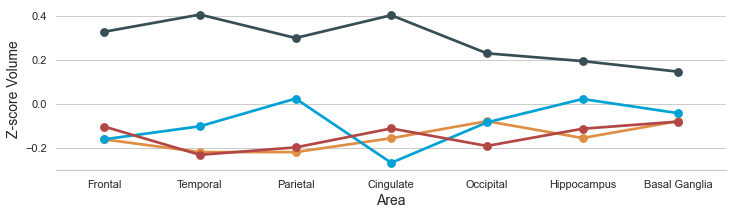

In [170]:
drawAtrophyDf = pd.melt(AtrophyDf,id_vars=['Subtype'])
plt.figure(figsize=[12,3])
sns.set_theme(style="whitegrid")
ax = sns.pointplot(x='variable',y='value',hue='Subtype',data=drawAtrophyDf,ci=None,palette = sns.color_palette(["#374E55FF","#DF8F44FF","#00A1D5FF","#B24745FF"]),legend=False)
sns.despine(left=True)
ax.get_legend().remove()
ax.set_xlabel('Area',fontsize=14)
ax.set_ylabel('Z-score Volume',fontsize=14)
plt.savefig('./DrawGMV/lineCompare.svg',dpi=300,bbox_inches='tight')

统计

In [90]:
from stats import oneway_Anova
columns = ['Frontal','Temporal','Parietal','Cingulate','Occipital','Hippocampus','BG']
resData = pd.DataFrame(
        columns=['Item', 'F', 'P', 'ST1-2T', 'ST1-2P', 'ST1-3T', 'ST1-3P', 'ST1-4T', 'ST1-4P', 'ST2-3T', 'ST2-3P',
                 'ST2-4T', 'ST2-4P', 'ST3-4T', 'ST3-4P'])
AtrophyDf['BG'] = AtrophyDf['Basal Ganglia']
AtrophyDf['Subtype'] = AtrophyDf['Subtype'].astype('int64')+1
AtrophyDf['Subtype'] = AtrophyDf['Subtype'].astype('object')
for c in columns:
    resultsDict = {}
    res = oneway_Anova(AtrophyDf,c,'Subtype')
    resultsDict['Item'] = c
    resultsDict['F'] = res.loc['Subtype','F']
    resultsDict['P'] = res.loc['Subtype','PR(>F)']

    print('====================================================')
    print(res)
    for c1 in [1,2,3]:
        for c2 in range(c1+1,5):
            t,p = scipy.stats.ttest_ind(AtrophyDf.loc[AtrophyDf['Subtype']== c1,c],
                                        AtrophyDf.loc[AtrophyDf['Subtype']== c2,c])

            resultsDict['ST%d-%dT' % (c1,c2)] = t
            resultsDict['ST%d-%dP' % (c1,c2)] = p
    
    resData = resData.append(pd.DataFrame(resultsDict,index=[0]))
    print(resData)
    print('====================================================')
resData.to_csv('table/RegionalGMV_ANOVA2.csv')

Frontal~Subtype
             df      sum_sq   mean_sq         F    PR(>F)
Subtype     3.0   18.111355  6.037118  6.274495  0.000366
Residual  373.0  358.888645  0.962168       NaN       NaN
      Item         F         P    ST1-2T    ST1-2P    ST1-3T    ST1-3P  \
0  Frontal  6.274495  0.000366  3.893297  0.000129  3.355901  0.000947   

     ST1-4T    ST1-4P    ST2-3T    ST2-3P    ST2-4T    ST2-4P    ST3-4T  \
0  2.423349  0.016421 -0.075208  0.940124 -0.522103  0.602263 -0.411401   

     ST3-4P  
0  0.681417  
Temporal~Subtype
             df      sum_sq   mean_sq          F    PR(>F)
Subtype     3.0   28.460707  9.486902  10.152699  0.000002
Residual  373.0  348.539293  0.934422        NaN       NaN
       Item          F         P    ST1-2T    ST1-2P    ST1-3T    ST1-3P  \
0   Frontal   6.274495  0.000366  3.893297  0.000129  3.355901  0.000947   
0  Temporal  10.152699  0.000002  5.021869  0.000001  3.821435  0.000177   

     ST1-4T    ST1-4P    ST2-3T    ST2-3P    ST2-4T    ST2-

In [66]:
AtrophyDf['Subtype'][0]==2

False

In [68]:
AtrophyDf.loc[AtrophyDf['Subtype']== c2,c]

3      1.469414
5      1.942176
9     -0.725093
10    -0.452472
13     0.503523
         ...   
360   -1.226208
363   -0.399239
364   -1.150714
369   -1.878382
373    0.902576
Name: BG, Length: 120, dtype: float64

In [ ]:
Regional_volume_Df = pd.DataFrame(columns=['Subtype','Atrophy','Area'])
for i in range(4):
    ts = []
    for j,name in enumerate(names):
        ts.append(scipy.stats.ttest_ind(Regional_volume[AD_Cluster==i,j],NC_Regional_volume[:,j])[0])
        AtrophyDf = AtrophyDf.append(pd.DataFrame(dict(Subtype='ST'+str(i+1),Atrophy=ts[-1],Area=name),index=[0]))
    for t in ts:
        print(t,end=',')
    print()

In [145]:
BN_274 = nib.load()

(377, 5)

In [198]:
import nibabel as nib

In [205]:
BN_274 = nib.load(BN_atlas)

In [206]:
BN_274_Data = BN_274.get_fdata()
BN_274_Data = np.nan_to_num(BN_274_Data)
BN_274_Data[BN_274_Data>210] = 0
nib.Nifti1Image(BN_274_Data,BN_274.affine).to_filename('E:/brain/BNatlas/BN_Atlas_210_1mm.nii')

# roi mapping

In [224]:
colors_in = [58/255,76/255,81/255]

In [225]:
with open('DrawGMV/ROI_Mapping_1.txt','w') as f:
    for i in range(263):
        f.write('%d,%d,%d,%d\n'%(i,colors_in[0],colors_in[1],colors_in[2]))